#### Instructions:  
1. Libraries allowed: **Python basic libraries, numpy, matplotlib and low level functions from opencv** except the functions explicitly mentioned.
2. Show all outputs.
3. Submit jupyter notebook and a pdf export of the notebook. 


## Task
The task is to stitch images to create a panoramic image.

## Image stitching - Two images

Q1. Keypoint detection and matching
1. Collect two images of a distant scene with approximately 50% overlap. Visualize.
2. Apply sift to extract keypoint and descriptor. Use OpenCV classes/methods.
3. Match the keypoints. Use knnmatch from opencv to get two best match and then use ratio test to filter out bad matches. Follow the tutorials at https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html .
4. Visualuze the good matches.


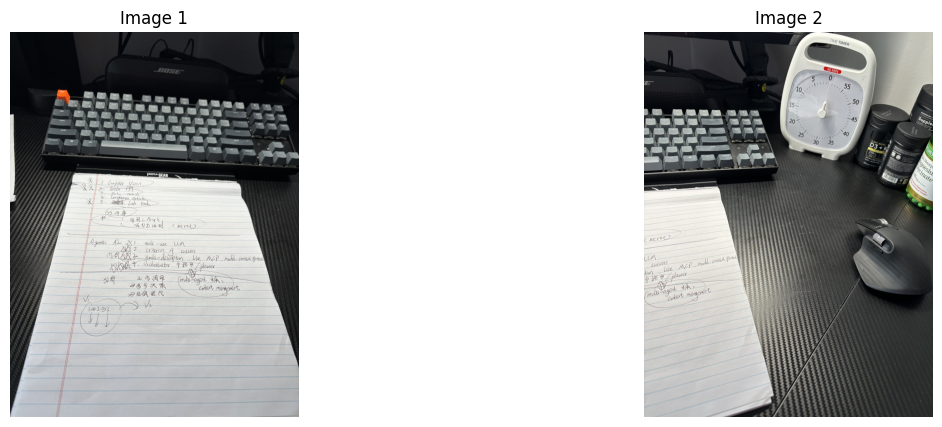

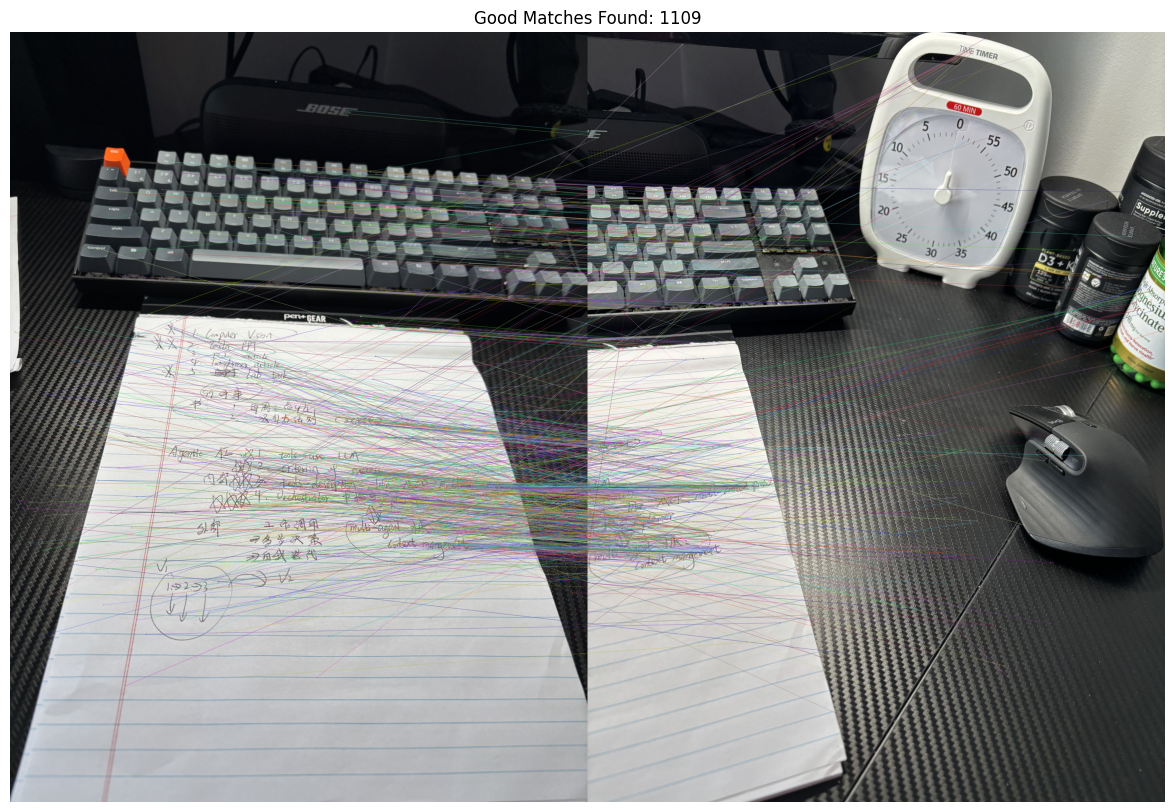

In [11]:
# code
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the images
img1 = cv2.imread('Assignment3-img1.jpg')
img2 = cv2.imread('Assignment3-img2.jpg')

# Convert BGR to RGB for visualization
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Visualize the two input images
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(img1_rgb)
plt.title('Image 1')
plt.axis('off')

plt.subplot(122)
plt.imshow(img2_rgb)
plt.title('Image 2')
plt.axis('off')
plt.show()

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(img1_rgb, None)
kp2, des2 = sift.detectAndCompute(img2_rgb, None)

# Initialize BF matcher with default params and knnMatch
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Visualize the matches
match_img = cv2.drawMatches(img1_rgb, kp1, img2_rgb, kp2, good_matches, None,
                           flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 10))
plt.imshow(match_img)
plt.title(f'Good Matches Found: {len(good_matches)}')
plt.axis('off')
plt.show()

Q2. Homograpy
1. Apply RANSAC With DLT to the matched keypoints in the previous step to find the homography from image 1 to 2 or from image 2 to 1. Either will work. In opencv, this can be done with`findHomography()`.
2. Print the homography matrix.
3. Select one of the image as reference image. Apply `cv.perspectiveTransform()` to the other image to find where the four cornes of an image will be transformed to. This along with image size of the reference image will give you what the output 
4. Transformm images with `cv.warpPerspective()` so that both images are aligned. In opencv, negative coordinates are discarded. You might need to do a translation prior to applying the homography if a transformation results in negative coordinates. Make sure that no imaformation is lost.
5. Visualize the images after alignment


Homography matrix:
[[ 1.34788992e+00 -1.12092624e-01 -2.92111510e+03]
 [ 3.31207624e-02  1.20934831e+00  8.47265720e+01]
 [ 7.95361181e-05 -4.81907233e-06  1.00000000e+00]]


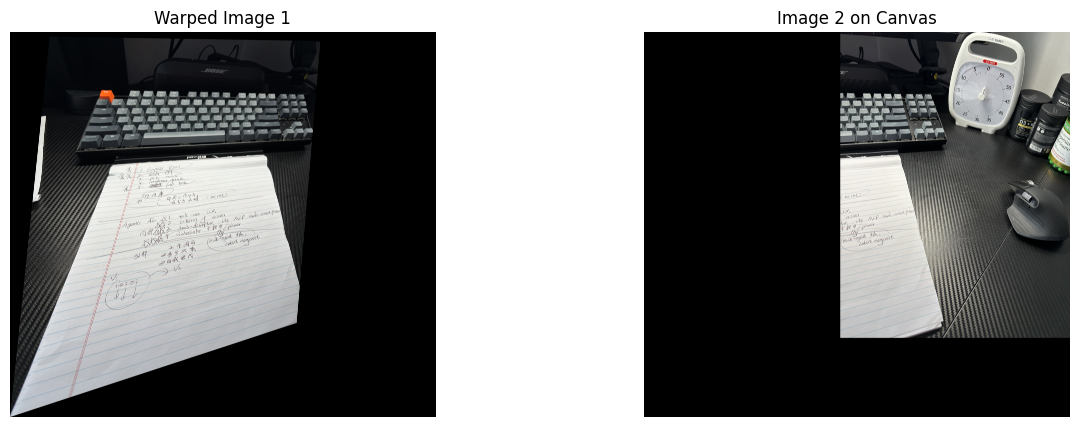

In [12]:
#code
# Extract location of good matches
points1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
points2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Find homography using RANSAC
H, mask = cv2.findHomography(points1, points2, cv2.RANSAC, 5.0)
print('Homography matrix:')
print(H)

# Get dimensions
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

# Get corners of img1
corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)

# Transform corners to img2 space
corners2_transform = cv2.perspectiveTransform(corners1, H)

# Get the minimum x and y coordinates
min_x = min(0, corners2_transform[:, 0, 0].min())
min_y = min(0, corners2_transform[:, 0, 1].min())

# Translation matrix to handle negative coordinates
translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])

# Update homography with translation
H_translated = translation_matrix.dot(H)

# Get new image dimensions
corners2_transform_translated = cv2.perspectiveTransform(corners1, H_translated)
max_x = max(w2 - min_x, corners2_transform_translated[:, 0, 0].max())
max_y = max(h2 - min_y, corners2_transform_translated[:, 0, 1].max())

# Warp image1
output_size = (int(max_x), int(max_y))
warped_img1 = cv2.warpPerspective(img1, H_translated, output_size)

# Create canvas for image2
canvas = np.zeros((int(max_y), int(max_x), 3), dtype=np.uint8)
canvas[-int(min_y):h2-int(min_y), -int(min_x):w2-int(min_x)] = img2

# Visualize aligned images
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(warped_img1, cv2.COLOR_BGR2RGB))
plt.title('Warped Image 1')
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title('Image 2 on Canvas')
plt.axis('off')
plt.show()

Q3. Bledning
1. Blend the two images togetehr by taking averages of the two images in the overlapped region.
2. Display the final blended image.

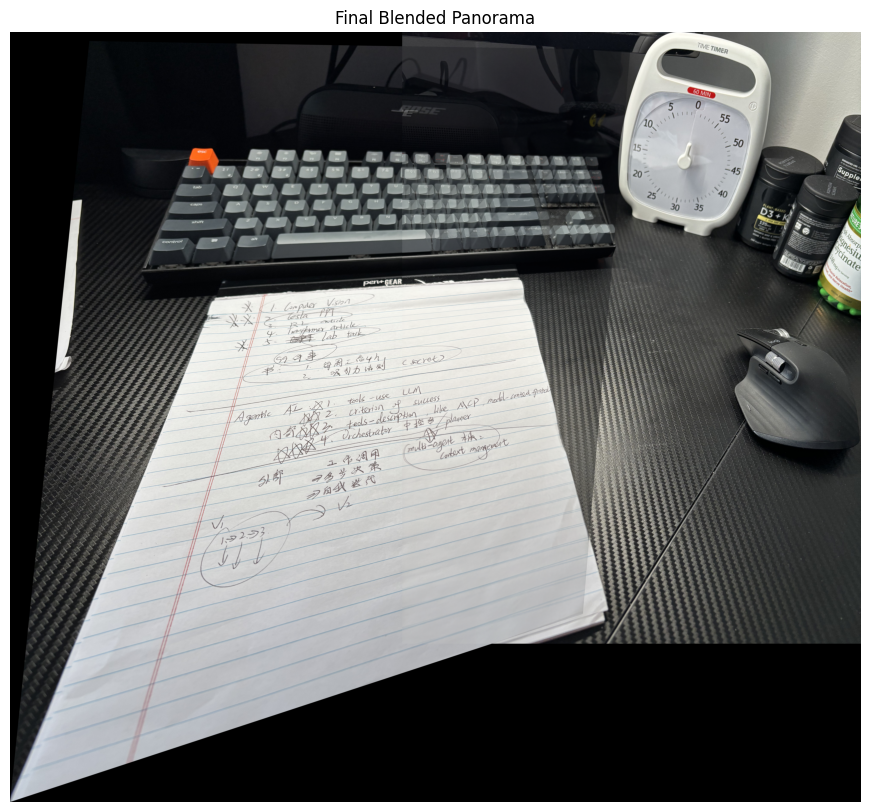

In [13]:
# code
# Create a mask for the overlapping region
overlap_mask = np.logical_and(warped_img1 != 0, canvas != 0)

# Create the final blended image
blended = np.copy(canvas)
blended[warped_img1 != 0] = warped_img1[warped_img1 != 0]  # Copy non-zero pixels from warped_img1

# Average the overlapping regions
blended[overlap_mask] = (0.5 * warped_img1[overlap_mask] + 0.5 * canvas[overlap_mask]).astype(np.uint8)

# Display the final result
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
plt.title('Final Blended Panorama')
plt.axis('off')
plt.show()

## Panomramic image

Q1. 
1. Collect iamges covering $360\degree$ of a scene by pure camera rotation. 
2. Follow the tutorials on https://docs.opencv.org/4.x/d8/d19/tutorial_stitcher.html to build a panormaic image projected on a "cylindrical surface".

Found 16 images for stitching


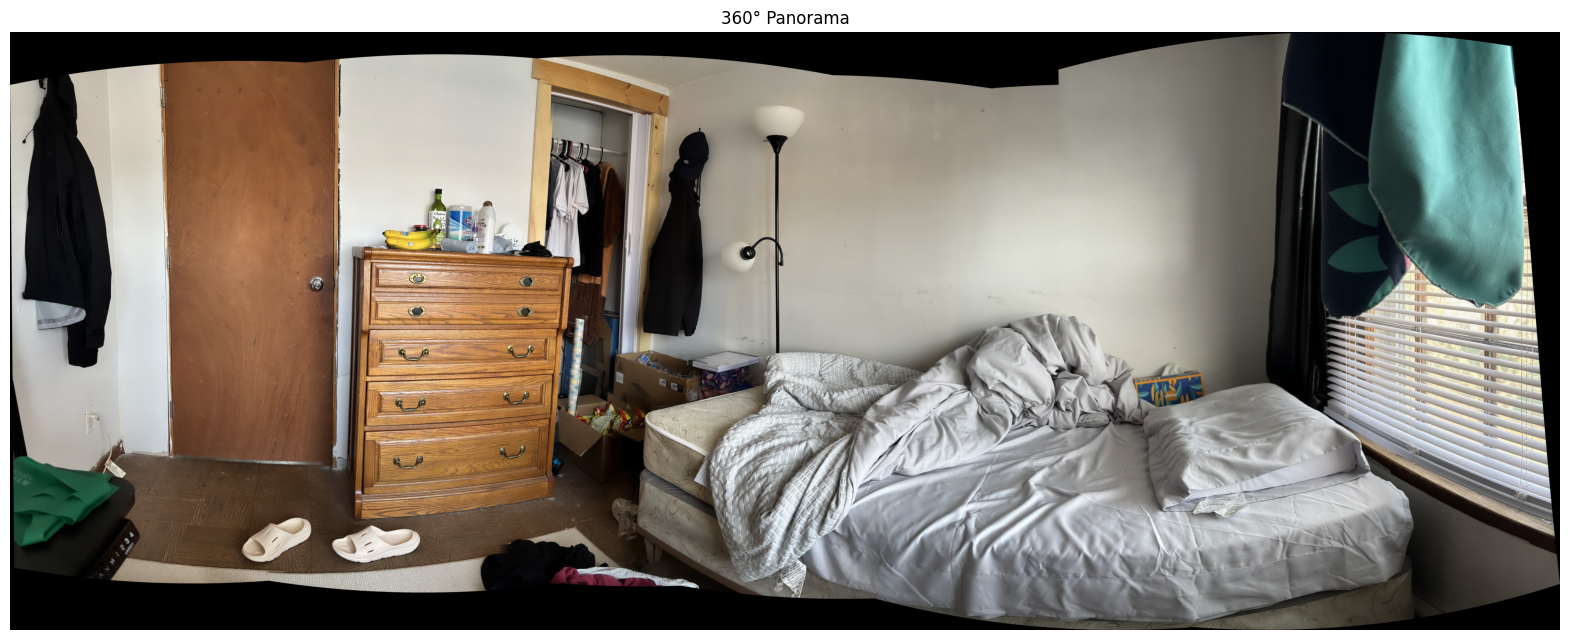

Panorama saved as panorama_result.jpg


In [14]:
import os

# Create a Stitcher object
stitcher = cv2.Stitcher.create(mode=cv2.Stitcher_PANORAMA)

# Read all images from the panorama_img folder
panorama_folder = 'panorama_img'
image_files = sorted([f for f in os.listdir(panorama_folder) if f.endswith('.jpg')])

# Read all images in the sequence
images = []
for image_file in image_files:
    img_path = os.path.join(panorama_folder, image_file)
    img = cv2.imread(img_path)
    if img is not None:
        images.append(img)

print(f'Found {len(images)} images for stitching')

if len(images) > 0:
    # Stitch the images
    status, panorama = stitcher.stitch(images)

    if status == cv2.Stitcher_OK:
        # Display the panorama
        plt.figure(figsize=(20, 10))
        plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
        plt.title('360° Panorama')
        plt.axis('off')
        plt.show()
        
        # Save the panorama
        cv2.imwrite('panorama_result.jpg', panorama)
        print('Panorama saved as panorama_result.jpg')
    else:
        print(f'Error during stitching (status code: {status})')
else:
    print(f'No images found in {panorama_folder} folder')